# Herschel Stripe 82 DECAM merging

Both DES and DECaLS provide DECam fluxes which have overlapping coverage. We chose which to use DES preferentially. In this notebook we cross match both catalogues and take the DES fluxes where available, using DECaLS otherwise

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-23 15:38:22.712743


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
des = Table.read("{}/DES.fits".format(TMP_DIR))
decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))

In [5]:
for col in des.colnames:
    if '_decam_' in col:
        des[col].name = col.replace('_decam_', '_des-decam_')
        
for col in decals.colnames:
    if '_decam_' in col:
        decals[col].name = col.replace('_decam_', '_decals-decam_')

## II - Merging tables

We first merge DES and DECaLS.

At every step, we look at the distribution of the distances separating the sources from one catalogue to the other (within a maximum radius) to determine the best cross-matching radius.

### DES

In [6]:
master_catalogue = des
master_catalogue['des_ra'].name = 'ra'
master_catalogue['des_dec'].name = 'dec'


## Add DECaLS

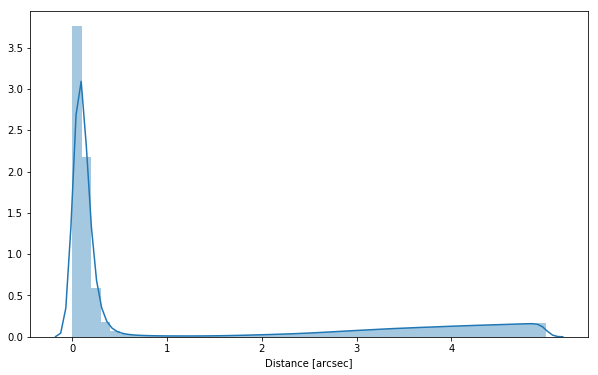

In [7]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(decals['decals_ra'], decals['decals_dec'])
)

In [8]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, decals, "decals_ra", "decals_dec", radius=0.8*u.arcsec)


### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [9]:
for col in master_catalogue.colnames:
    if (col.startswith("m_")  
        or col.startswith("merr_") 
        or col.startswith("f_")
        or col.startswith("ferr_")
        or "stellarity" in col):
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [10]:
master_catalogue[:10].show_in_notebook()

idx,des_id,ra,dec,des_stellarity,m_des-decam_g,merr_des-decam_g,m_ap_des-decam_g,merr_ap_des-decam_g,m_des-decam_r,merr_des-decam_r,m_ap_des-decam_r,merr_ap_des-decam_r,m_des-decam_i,merr_des-decam_i,m_ap_des-decam_i,merr_ap_des-decam_i,m_des-decam_z,merr_des-decam_z,m_ap_des-decam_z,merr_ap_des-decam_z,m_des-decam_y,merr_des-decam_y,m_ap_des-decam_y,merr_ap_des-decam_y,f_des-decam_g,ferr_des-decam_g,flag_des-decam_g,f_ap_des-decam_g,ferr_ap_des-decam_g,f_des-decam_r,ferr_des-decam_r,flag_des-decam_r,f_ap_des-decam_r,ferr_ap_des-decam_r,f_des-decam_i,ferr_des-decam_i,flag_des-decam_i,f_ap_des-decam_i,ferr_ap_des-decam_i,f_des-decam_z,ferr_des-decam_z,flag_des-decam_z,f_ap_des-decam_z,ferr_ap_des-decam_z,f_des-decam_y,ferr_des-decam_y,flag_des-decam_y,f_ap_des-decam_y,ferr_ap_des-decam_y,des_flag_cleaned,des_flag_gaia,flag_merged,decals_id,f_decals-decam_g,f_decals-decam_r,f_decals-decam_z,ferr_decals-decam_g,ferr_decals-decam_r,ferr_decals-decam_z,f_ap_decals-decam_g,f_ap_decals-decam_r,f_ap_decals-decam_z,ferr_ap_decals-decam_g,ferr_ap_decals-decam_r,ferr_ap_decals-decam_z,m_decals-decam_g,merr_decals-decam_g,flag_decals-decam_g,m_decals-decam_r,merr_decals-decam_r,flag_decals-decam_r,m_decals-decam_z,merr_decals-decam_z,flag_decals-decam_z,m_ap_decals-decam_g,merr_ap_decals-decam_g,m_ap_decals-decam_r,merr_ap_decals-decam_r,m_ap_decals-decam_z,merr_ap_decals-decam_z,decals_stellarity,decals_flag_cleaned,decals_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,64025141,29.9625519246,1.85748200299,0.999808073044,14.7785787582,0.000169810955413,14.7558808327,0.000194271895452,17.2212200165,0.00187869311776,19.5404887199,0.00573418522254,17.2754516602,0.00269640679471,19.7815818787,0.00845393631607,16.8895683289,0.00280157546513,19.2856321335,0.00837686192244,14.114730835,0.000847931951284,14.2826442719,0.000454342749435,4452.13676257,0.696321623951,False,4546.19088549,0.813454609455,469.366396087,0.812163593856,False,55.4376116741,0.292787080546,446.497812932,1.10886947616,False,44.3983927369,0.345702006702,637.048750837,1.6438064261,False,70.1047018468,0.54088406089,8205.54943026,6.40832230635,False,7029.78902343,2.94172162525,False,3,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,False,0
1,125273261,350.182969925,-1.11147799701,0.999714136124,15.1518802643,0.000227634664043,15.1361632347,0.000221034570131,16.8090610504,0.00155073637143,19.2481913567,0.00433425419033,16.0775794983,0.00140306528192,18.8761940002,0.00271435640752,15.1594200134,0.00107244541869,18.0925111771,0.00231030769646,13.5575237274,0.000720222247764,15.9740076065,0.00179049849976,3156.80600679,0.661853654373,False,3202.83603515,0.652034521027,686.081296182,0.979916866623,False,72.5643747192,0.289676667147,1345.76181292,1.73908880367,False,102.216828031,0.255543566574,3134.95993312,3.09658405357,False,210.375678262,0.447652520482,13708.5180757,9.09353456093,False,1480.46095297,2.44144305369,False,2,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,False,0
2,278039760,12.5945959246,-1.16716099701,0.999854385853,14.6528301239,0.000183248586836,14.8702502251,0.000221354886889,16.9759902954,0.00172981689684,19.466565609,0.00482370331883,16.7956581116,0.00238565751351,19.3058948517,0.00429996615276,16.3071155548,0.00273376447149,18.9444150925,0.00722197024152,13.2948598862,0.00049654772738,13.7064313889,0.000373695016606,4998.82519913,0.843692647964,False,4091.66350011,0.834189471888,588.306818403,0.937302330475,False,59.3435819269,0.263651365624,694.603161007,1.52623191776,False,68.8084950626,0.272510208736,1089.31573771,2.74277734217,False,95.9917618823,0.638506521848,17460.4746512,7.98532734659,False,11951.6383858,4.11358457558,False,3,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,nan,nan,nan,n

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [11]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="decam_flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [12]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="decam_flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.

In [13]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

master_catalogue.add_column(Column(
    data=np.nanmax([master_catalogue[column] for column in stellarity_columns], axis=0),
    name="decam_stellarity"
))
master_catalogue.remove_columns(stellarity_columns)

## VIII - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogue. This can be used to easily get additional information from them.

In [14]:
master_catalogue.add_column(Column(data=np.arange(len(master_catalogue)), 
                              name="decam_intid"))


In [15]:

id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['des_id', 'decals_id', 'decam_intid']


## VI - Choosing between multiple values for the same filter



In [16]:
decam_origin = Table()
decam_origin.add_column(master_catalogue['decam_intid'])

In [17]:
decam_stats = Table()
decam_stats.add_column(Column(data=['g','r','i','z','y'], name="Band"))
for col in ["DES", "DECaLS"]:
    decam_stats.add_column(Column(data=np.full(5, 0), name="{}".format(col)))
    decam_stats.add_column(Column(data=np.full(5, 0), name="use {}".format(col)))
    decam_stats.add_column(Column(data=np.full(5, 0), name="{} ap".format(col)))
    decam_stats.add_column(Column(data=np.full(5, 0), name="use {} ap".format(col)))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(5, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [18]:
decam_bands = ['g','r','i','z','y'] # Lowercase naming convention (k is Ks)
for band in decam_bands:
    if (band == 'i') or (band == 'y'):
        master_catalogue["f_des-decam_{}".format(band)].name = "f_decam_{}".format(band)
        master_catalogue["ferr_des-decam_{}".format(band)].name = "ferr_decam_{}".format(band)
        master_catalogue["m_des-decam_{}".format(band)].name = "m_decam_{}".format(band)
        master_catalogue["merr_des-decam_{}".format(band)].name = "merr_decam_{}".format(band)
        master_catalogue["f_ap_des-decam_{}".format(band)].name = "f_ap_decam_{}".format(band)
        master_catalogue["ferr_ap_des-decam_{}".format(band)].name = "ferr_ap_decam_{}".format(band)
        master_catalogue["m_ap_des-decam_{}".format(band)].name = "m_ap_decam_{}".format(band)
        master_catalogue["merr_ap_des-decam_{}".format(band)].name = "merr_ap_decam_{}".format(band)
        master_catalogue["flag_des-decam_{}".format(band)].name = "flag_decam_{}".format(band)
        
        continue

    # DECam total flux 
    has_des = ~np.isnan(master_catalogue['f_des-decam_' + band])
    has_decals = ~np.isnan(master_catalogue['f_decals-decam_' + band])

    use_des = has_des 
    use_decals = has_decals & ~has_des


    f_decam = np.full(len(master_catalogue), np.nan)
    f_decam[use_des] = master_catalogue['f_des-decam_' + band][use_des]
    f_decam[use_decals] = master_catalogue['f_decals-decam_' + band][use_decals]

    ferr_decam = np.full(len(master_catalogue), np.nan)
    ferr_decam[use_des] = master_catalogue['ferr_des-decam_' + band][use_des]
    ferr_decam[use_decals] = master_catalogue['ferr_decals-decam_' + band][use_decals]
    
    m_decam = np.full(len(master_catalogue), np.nan)
    m_decam[use_des] = master_catalogue['m_des-decam_' + band][use_des]
    m_decam[use_decals] = master_catalogue['m_decals-decam_' + band][use_decals]
    
    merr_decam = np.full(len(master_catalogue), np.nan)
    merr_decam[use_des] = master_catalogue['merr_des-decam_' + band][use_des]
    merr_decam[use_decals] = master_catalogue['merr_decals-decam_' + band][use_decals]
    
    flag_decam = np.full(len(master_catalogue), False, dtype=bool)
    flag_decam[use_des] = master_catalogue['flag_des-decam_' + band][use_des]
    flag_decam[use_decals] = master_catalogue['flag_decals-decam_' + band][use_decals]

    master_catalogue.add_column(Column(data=f_decam, name="f_decam_" + band))
    master_catalogue.add_column(Column(data=ferr_decam, name="ferr_decam_" + band))
    master_catalogue.add_column(Column(data=m_decam, name="m_decam_" + band))
    master_catalogue.add_column(Column(data=merr_decam, name="merr_decam_" + band))
    master_catalogue.add_column(Column(data=flag_decam, name="flag_decam_" + band))


    old_des_columns = ['f_des-decam_' + band,
                               'ferr_des-decam_' + band,
                               'm_des-decam_' + band, 
                               'merr_des-decam_' + band,
                               'flag_des-decam_' + band]
    old_decals_columns =      ['f_decals-decam_' + band,
                               'ferr_decals-decam_' + band,
                               'm_decals-decam_' + band, 
                               'merr_decals-decam_' + band,
                               'flag_decals-decam_' + band]
    
    old_columns = old_des_columns + old_decals_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_des] = "DES"
    origin[use_decals] = "DECaLS"

    
    decam_origin.add_column(Column(data=origin, name= 'f_decam_' + band ))
    
    # DECam aperture flux 
 
    has_ap_des = ~np.isnan(master_catalogue['f_ap_des-decam_' + band])
    has_ap_decals = ~np.isnan(master_catalogue['f_ap_decals-decam_' + band])

    use_ap_des = has_ap_des 
    use_ap_decals = has_ap_decals & ~has_ap_des


    f_ap_decam = np.full(len(master_catalogue), np.nan)
    f_ap_decam[use_ap_des] = master_catalogue['f_ap_des-decam_' + band][use_ap_des]
    f_ap_decam[use_ap_decals] = master_catalogue['f_ap_decals-decam_' + band][use_ap_decals]

    ferr_ap_decam = np.full(len(master_catalogue), np.nan)
    ferr_ap_decam[use_ap_des] = master_catalogue['ferr_ap_des-decam_' + band][use_ap_des]
    ferr_ap_decam[use_ap_decals] = master_catalogue['ferr_ap_decals-decam_' + band][use_ap_decals]
    
    m_ap_decam = np.full(len(master_catalogue), np.nan)
    m_ap_decam[use_ap_des] = master_catalogue['m_ap_des-decam_' + band][use_ap_des]
    m_ap_decam[use_ap_decals] = master_catalogue['m_ap_decals-decam_' + band][use_ap_decals]
    
    merr_ap_decam = np.full(len(master_catalogue), np.nan)
    merr_ap_decam[use_ap_des] = master_catalogue['merr_ap_des-decam_' + band][use_ap_des]
    merr_ap_decam[use_ap_decals] = master_catalogue['merr_ap_decals-decam_' + band][use_ap_decals]
    

    master_catalogue.add_column(Column(data=f_ap_decam, name="f_ap_decam_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_decam, name="ferr_ap_decam_" + band))
    master_catalogue.add_column(Column(data=m_ap_decam, name="m_ap_decam_" + band))
    master_catalogue.add_column(Column(data=merr_ap_decam, name="merr_ap_decam_" + band))
  


    old_ap_des_columns = ['f_ap_des-decam_' + band,
                               'ferr_ap_des-decam_' + band,
                               'm_ap_des-decam_' + band, 
                               'merr_ap_des-decam_' + band]
    old_ap_decals_columns =      ['f_ap_decals-decam_' + band,
                               'ferr_ap_decals-decam_' + band,
                               'm_ap_decals-decam_' + band, 
                               'merr_ap_decals-decam_' + band]
    
    old_ap_columns = old_ap_des_columns + old_ap_decals_columns
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_des] = "DES"
    origin_ap[use_ap_decals] = "DECaLS"

    
    decam_origin.add_column(Column(data=origin_ap, name= 'f_ap_decam_' + band ))    

   
    decam_stats['DES'][decam_stats['Band'] == band] = np.sum(has_des)
    decam_stats['DECaLS'][decam_stats['Band'] == band] = np.sum(has_decals)

    decam_stats['use DES'][decam_stats['Band'] == band] = np.sum(use_des)
    decam_stats['use DECaLS'][decam_stats['Band'] == band] = np.sum(use_decals)

    decam_stats['DES ap'][decam_stats['Band'] == band] = np.sum(has_ap_des)
    decam_stats['DECaLS ap'][decam_stats['Band'] == band] = np.sum(has_ap_decals)

    decam_stats['use DES ap'][decam_stats['Band'] == band] = np.sum(use_ap_des)
    decam_stats['use DECaLS ap'][decam_stats['Band'] == band] = np.sum(use_ap_decals)


In [19]:
decam_stats.show_in_notebook()

idx,Band,DES,use DES,DES ap,use DES ap,DECaLS,use DECaLS,DECaLS ap,use DECaLS ap
0,g,17916439.0,17916439.0,18075684.0,18075684.0,23814977.0,7378586.0,22206932.0,6140393.0
1,r,18364250.0,18364250.0,18386425.0,18386425.0,23839774.0,7068402.0,22971963.0,6354364.0
2,i,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,z,18240782.0,18240782.0,18320913.0,18320913.0,24032002.0,7309679.0,22011790.0,5699597.0
4,y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
decam_origin.write("{}/herschel-stripe-82_decam_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## IX - Saving the catalogue

In [21]:
master_catalogue.colnames

['des_id',
 'ra',
 'dec',
 'm_decam_i',
 'merr_decam_i',
 'm_ap_decam_i',
 'merr_ap_decam_i',
 'm_decam_y',
 'merr_decam_y',
 'm_ap_decam_y',
 'merr_ap_decam_y',
 'f_decam_i',
 'ferr_decam_i',
 'flag_decam_i',
 'f_ap_decam_i',
 'ferr_ap_decam_i',
 'f_decam_y',
 'ferr_decam_y',
 'flag_decam_y',
 'f_ap_decam_y',
 'ferr_ap_decam_y',
 'flag_merged',
 'decals_id',
 'decam_flag_cleaned',
 'decam_flag_gaia',
 'decam_stellarity',
 'decam_intid',
 'f_decam_g',
 'ferr_decam_g',
 'm_decam_g',
 'merr_decam_g',
 'flag_decam_g',
 'f_ap_decam_g',
 'ferr_ap_decam_g',
 'm_ap_decam_g',
 'merr_ap_decam_g',
 'f_decam_r',
 'ferr_decam_r',
 'm_decam_r',
 'merr_decam_r',
 'flag_decam_r',
 'f_ap_decam_r',
 'ferr_ap_decam_r',
 'm_ap_decam_r',
 'merr_ap_decam_r',
 'f_decam_z',
 'ferr_decam_z',
 'm_decam_z',
 'merr_decam_z',
 'flag_decam_z',
 'f_ap_decam_z',
 'ferr_ap_decam_z',
 'm_ap_decam_z',
 'merr_ap_decam_z']

In [22]:
master_catalogue["ra"].name = "decam_ra"
master_catalogue["dec"].name = "decam_dec"
master_catalogue["flag_merged"].name = "decam_flag_merged"

In [23]:
columns = ["decam_intid", "des_id", "decals_id",
           'decam_ra', 'decam_dec', 'decam_flag_merged',  
           'decam_flag_cleaned',  'decam_flag_gaia', 'decam_stellarity']

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    


In [24]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: set()


In [25]:
master_catalogue[:10].show_in_notebook()

idx,des_id,decam_ra,decam_dec,m_decam_i,merr_decam_i,m_ap_decam_i,merr_ap_decam_i,m_decam_y,merr_decam_y,m_ap_decam_y,merr_ap_decam_y,f_decam_i,ferr_decam_i,flag_decam_i,f_ap_decam_i,ferr_ap_decam_i,f_decam_y,ferr_decam_y,flag_decam_y,f_ap_decam_y,ferr_ap_decam_y,decam_flag_merged,decals_id,decam_flag_cleaned,decam_flag_gaia,decam_stellarity,decam_intid,f_decam_g,ferr_decam_g,m_decam_g,merr_decam_g,flag_decam_g,f_ap_decam_g,ferr_ap_decam_g,m_ap_decam_g,merr_ap_decam_g,f_decam_r,ferr_decam_r,m_decam_r,merr_decam_r,flag_decam_r,f_ap_decam_r,ferr_ap_decam_r,m_ap_decam_r,merr_ap_decam_r,f_decam_z,ferr_decam_z,m_decam_z,merr_decam_z,flag_decam_z,f_ap_decam_z,ferr_ap_decam_z,m_ap_decam_z,merr_ap_decam_z
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,64025141,29.9625519246,1.85748200299,17.2754516602,0.00269640679471,19.7815818787,0.00845393631607,14.114730835,0.000847931951284,14.2826442719,0.000454342749435,446.497812932,1.10886947616,False,44.3983927369,0.345702006702,8205.54943026,6.40832230635,False,7029.78902343,2.94172162525,False,-1,False,3,0.999808073044,0,4452.13676257,0.696321623951,14.7785787582,0.000169810955413,False,4546.19088549,0.813454609455,14.7558808327,0.000194271895452,469.366396087,0.812163593856,17.2212200165,0.00187869311776,False,55.4376116741,0.292787080546,19.5404887199,0.00573418522254,637.048750837,1.6438064261,16.8895683289,0.00280157546513,False,70.1047018468,0.54088406089,19.2856321335,0.00837686192244
1,125273261,350.182969925,-1.11147799701,16.0775794983,0.00140306528192,18.8761940002,0.00271435640752,13.5575237274,0.000720222247764,15.9740076065,0.00179049849976,1345.76181292,1.73908880367,False,102.216828031,0.255543566574,13708.5180757,9.09353456093,False,1480.46095297,2.44144305369,False,-1,False,2,0.999714136124,1,3156.80600679,0.661853654373,15.1518802643,0.000227634664043,False,3202.83603515,0.652034521027,15.1361632347,0.000221034570131,686.081296182,0.979916866623,16.8090610504,0.00155073637143,False,72.5643747192,0.289676667147,19.2481913567,0.00433425419033,3134.95993312,3.09658405357,15.1594200134,0.00107244541869,False,210.375678262,0.447652520482,18.0925111771,0.00231030769646
2,278039760,12.5945959246,-1.16716099701,16.7956581116,0.00238565751351,19.3058948517,0.00429996615276,13.2948598862,0.00049654772738,13.7064313889,0.000373695016606,694.603161007,1.52623191776,False,68.8084950626,0.272510208736,17460.4746512,7.98532734659,False,11951.6383858,4.11358457558,False,-1,False,3,0.999854385853,2,4998.82519913,0.843692647964,14.6528301239,0.000183248586836,False,4091.66350011,0.834189471888,14.8702502251,0.000221354886889,588.306818403,0.937302330475,16.9759902954,0.00172981689684,False,59.3435819269,0.263651365624,19.466565609,0.00482370331883,1089.31573771,2.74277734217,16.3071155548,0.00273376447149,False,95.9917618823,0.638506521848,18.9444150925,0.00722197024152
3,124464173,350.223941925,-1.03165599701,17.5804328918,0.00345048541203,19.976228714,0.0100552951917,14.0906438828,0.000809056509752,14.184463501,0.000440186529886,337.152856274,1.0714766691,False,37.1115005183,0.343699593956,8389.62302494,6.25168350557,False,7695.10587595,3.11980197197,False,-1,False,3,0.99947810173,3,3034.69959976,0.578706663338,15.1947107315,0.000207046119613,False,3369.25642522,0.690281942399,15.0811648369,0.000222441987717,357.419131687,0.61548693761,17.5170555115,0.00186967174523,False,45.8809200502,0.212118763935,19.7459197044,0.00501962518319,436.630413437,2.04786976698,17.2997150421,0.00509228464216,False,40.554981228,0.656015399326,19.8798894882,0.0175628159195
4,130230378,351.415346925,1.87702600299,17.7257061005,0.00469403807074,20.5073833466,0.0116493497044,13.7598619461,0.000596803438384,13.9582595825,0.000316018849844,294.929055367,1.27508708652,False,22.7534188445,0.244131614961,11377.7194699,6.25406251613,False,9477.55180503,2.75857524842,False,-1,False,3,0.998991191387,4,3960.25508054,0.713242395527,14.9056921005,0.000195541215362,False,3696.45006258,0.762831778611,14.98053

In [26]:
master_catalogue[columns].write("{}/decam_merged_catalogue_herschel-stripe-82.fits".format(TMP_DIR), overwrite=True)